In [136]:
import numpy as np
import pandas as pd
import re
from seaborn import pairplot, kdeplot
import matplotlib.pyplot as pl

In [122]:
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
%matplotlib inline

In [111]:
with open('./nomad_seawifs_v1.3_2005262.txt') as f:
    for i, line in enumerate(f.readlines()):
        if 'fields' in line:
            col_names = line.strip('/fields=').strip().split(',')
        if '/end_header' in line:
            rowskips = i+1
            break
df = pd.read_csv('./nomad_seawifs_v1.3_2005262.txt', header=None, names=col_names, skiprows=rowskips,
                na_values=-999)

In [112]:
df.head()

,year,month,day,hour,minute,second,lat,lon,id,oisst,...,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid
0,1997,10,7,9,41,0,42.5100,39.5200,4065,19.54,...,0.00345,0.00297,0.00217,0.00026,S1997280094210.L1A_GAC,480,49.0,25.4,0.2098,0
1,1997,10,11,9,32,0,39.2900,25.1100,4069,19.57,...,0.00494,0.00348,0.00191,0.00018,S1997284110315.L1A_MLAC,5880,48.7,37.8,0.1043,1
2,1997,9,27,11,29,0,24.1392,-20.9995,6083,24.67,...,0.00625,0.00375,0.00168,0.00022,S1997270134450.L1A_MLAC,8880,28.0,35.5,0.1012,1
3,1998,5,16,8,30,0,-32.3397,17.8766,6119,17.21,...,0.00177,0.00193,0.00196,0.00055,S1998136102611.L1A_MLAC,7200,51.6,22.4,0.0940,1
4,1998,5,16,9,16,0,-32.3447,17.8735,6120,17.21,...,0.00180,0.00198,0.00199,0.00056,S1998136102611.L1A_MLAC,4440,51.6,22.4,0.0836,1


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Columns: 169 entries, year to valid
dtypes: float64(157), int64(10), object(2)
memory usage: 385.6+ KB


In [161]:
date_time_columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
df.insert(0, 'datetime', pd.to_datetime(df[date_time_columns], format='%Y-%m-%d %H:%M:%S'))

In [162]:
df.drop(date_time_columns, axis=1, inplace=True)

In [102]:
name_set = set()
matcher = re.compile('[\D]+')
for name in df.columns:
    try:
        match = matcher.findall(name)[0]
        name_set.add(match)
    except IndexError:
        continue

In [103]:
print(name_set)

{'sat_rrs', 'lat', 'cruise', 'kd', 'id', 'flag', 'cv', 'datetime', 'chl', 'tdiff', 'bb', 'lon', 'chl_a', 'senz', 'oisst', 'lw', 'sal', 'ap', 'valid', 'sat_file', 'ad', 'etopo', 'wt', 'solz', 'ag', 'es'}


In [ ]:
df[['sat_rrs', 'senz', 'sal', 'oisst', 'chl_a', 'wt']]

In [114]:
df.filter(regex='chl', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 2 columns):
chl      262 non-null float64
chl_a    33 non-null float64
dtypes: float64(2)
memory usage: 4.6 KB


In [123]:
df[['wt', 'oisst']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 2 columns):
wt       97 non-null float64
oisst    292 non-null float64
dtypes: float64(2)
memory usage: 4.6 KB


/home/madhatter106/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/home/madhatter106/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


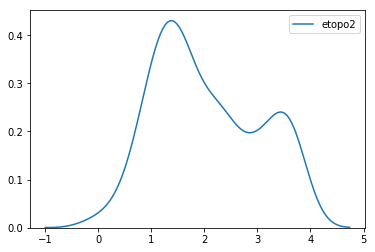

In [138]:
kdeplot(np.log10(df.etopo2));

In [155]:
df.loc[df.etopo2<=30, 'etopo2'].size / 292 * 100

32.534246575342465

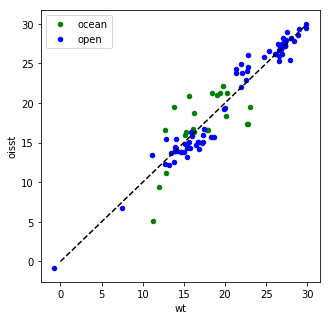

In [156]:
_, ax = pl.subplots(figsize=(5, 5))
df.loc[df.etopo2<=30, ].plot('wt', 'oisst', kind='scatter', ax=ax, color='g', label='ocean')
df.loc[df.etopo2>30, ].plot('wt', 'oisst', kind='scatter', ax=ax, color='b', label='open')
pl.plot([0, 30], [0, 30], ls='--', color='k');

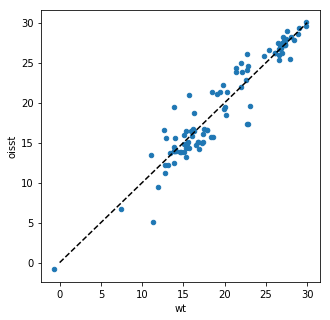

In [133]:
df.plot('wt', 'oisst', kind='scatter', figsize=(5, 5))
pl.plot([0, 30], [0, 30], ls='--', color='k');

In [119]:
def fill_chl(row):
    return row['chl_a'] if np.isfinite(row['chl_a']) else row['chl']
df['chlor_a'] = df.apply(fill_chl, axis=1)
df['is_hplc'] = np.isfinite(df['chl_a'])

In [157]:
causal_graph = CausalGraphicalModel(nodes=['sat_rrs', 'chlor_a', 'solz', 'oisst', 'etopo2', 'senz'],
                                   edges = [('chlor_a', 'sat_rrs'), ('senz', 'sat_rrs'), ('solz', 'sat_rrs'),
                                           ('oisst', 'chlor_a'), ('solz', 'chlor_a'), ('etopo2', 'chlor_a'),
                                           ('etopo2', 'sat_rrs')])

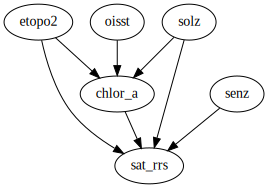

In [159]:
causal_graph.draw()

In [160]:
!conda install timezone

Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - timezone

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/free/linux-64
  - https://repo.anaconda.com/pkgs/free/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [188]:
import math
def Daylight(row):
    latitude = abs(row['lat'])
    day = row['dayofyear']
    P = math.asin(0.39795 * math.cos(0.2163108 + 2 * math.atan(0.9671396 * math.tan(.00860 * (day - 186)))))
    pi = math.pi
    daylightamount = sin24+(24 * cos-18^12)^(day)+(latitude)^24
    return daylightamount

In [189]:
df['dayofyear'] = df.datetime.dt.dayofyear
df['daylength'] = df.apply(Daylight, axis=1)

ValueError: ('math domain error', 'occurred at index 235')

In [185]:
df[['daylength']].describe()

,daylength
count,292.000000
mean,12.120861
std,0.022367
min,12.091048
25%,12.104019
50%,12.113027
75%,12.136398
max,12.196520


In [182]:
df[['dayofyear']].describe()

,dayofyear
count,292.000000
mean,163.154110
std,95.635585
min,11.000000
25%,63.000000
50%,182.000000
75%,243.500000
max,361.000000
